In [2]:
%pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=e8a32aee211edbe67a9153fe3e0a7c1e7318c3b949928034e623b9796aa81999
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [3]:
import wget
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xvf images.tar.gz
!tar -xvf annotations.tar.gz

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
annotations/trimaps/._pomeranian_180.png
annotations/trimaps/pomeranian_180.png
annotations/trimaps/._pomeranian_181.png
annotations/trimaps/pomeranian_181.png
annotations/trimaps/._pomeranian_182.png
annotations/trimaps/pomeranian_182.png
annotations/trimaps/._pomeranian_183.png
annotations/trimaps/pomeranian_183.png
annotations/trimaps/._pomeranian_184.png
annotations/trimaps/pomeranian_184.png
annotations/trimaps/._pomeranian_185.png
annotations/trimaps/pomeranian_185.png
annotations/trimaps/._pomeranian_186.png
annotations/trimaps/pomeranian_186.png
annotations/trimaps/._pomeranian_187.png
annotations/trimaps/pomeranian_187.png
annotations/trimaps/._pomeranian_188.png
annotations/trimaps/pomeranian_188.png
annotations/trimaps/._pomeranian_189.png
annotations/trimaps/pomeranian_189.png
annotations/trimaps/._pomeranian_19.png
annotations/trimaps/pomeranian_19.png
annotations/trimaps/._pomeranian_190.png
annotations/trimaps/pomeranian_190.png
annota

In [4]:
import os
input_dir = 'images/'
output_dir = 'annotations/trimaps/'

input_img_paths = sorted( ## 파일 시스템에서 파일을 읽을 때는 파일의 순서를 보장할 수 없음, 파일의 정렬된 순서를 보장하기 위해 sorted() 함수 사용
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith('.jpg') ## jpg 파일만 읽음
    ]
)

target_paths = sorted(
    [
        os.path.join(output_dir, fname)
        for fname in os.listdir(output_dir)
        if fname.endswith('.png') and not fname.startswith('.') ## png 파일만 읽음, 숨김 파일은 제외
    ]
)

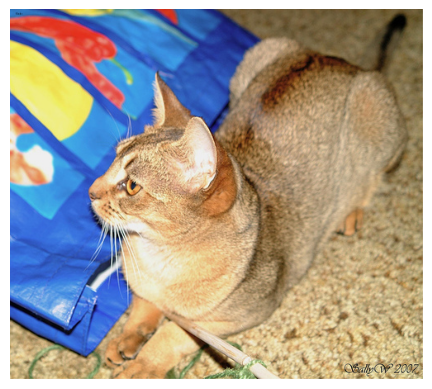

In [5]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array

plt.axis('off')
plt.imshow(load_img(input_img_paths[9]))

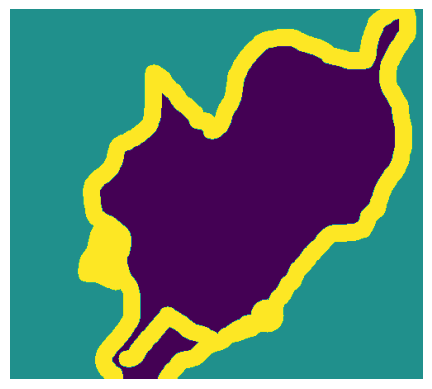

In [6]:
def display_target(target_array):
    normalized_array = (target_array.astype('uint8') - 1) * 127
    plt.axis('off')
    plt.imshow(normalized_array[:, :, 0])
img  = img_to_array(load_img(target_paths[9], color_mode='grayscale'))
display_target(img)

In [7]:
import numpy as np
import random

img_size = (200, 200) ## 입력과 타깃을 (200, 200) 크기로 변경
num_imgs = len(input_img_paths) ## 데이터에 있는 전체 샘플 개수 -> 7390

## (원래 품종별로 정렬되어 있기 때문에) 파일 경로를 뒤섞음.
## 입력 걍로와 타깃 결오가 동일한 순서를 유지하도록 두 명령에 같은 시드(1337)를 사용
## 시드 값은 난수 생성기를 초기화 하는데 사용
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_paths)

def path_to_input_image(path):
    return img_to_array(load_img(path, target_size=img_size)) ##numPy 배열로 변환

def path_to_target(path):
    img = img_to_array(load_img(path, target_size=img_size, color_mode='grayscale'))
    img = img.astype('uint8') - 1 ## 레이블이 0,1,2가 되도록 1을 뺌
    return img

## 전체 이미지를 input_imgs에 float32 배열로 로드하고 타깃 마스크는 targets에 unit8로 로드
## 입력은 3개의 채널(RGB 값)을 가지고 타깃은 (정수 레이블을 담은) 하나의 채널을 가짐
input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype='float32')
targets = np.zeros((num_imgs,) + img_size + (1,), dtype='uint8')
for i in range(num_imgs):
    input_imgs[i] = path_to_input_image(input_img_paths[i])
    targets[i] = path_to_target(target_paths[i])

num_val_samples = int(num_imgs * 0.2) ## 검증에 1000개의 샘플 사용

## 데이터를 훈련 세트와 검증 세트로 나눔
train_input_imgs = input_imgs[:-num_val_samples]
train_targets = targets[:-num_val_samples]
val_input_imgs = input_imgs[-num_val_samples:]
val_targets = targets[-num_val_samples:] ## 배열에서 마지막 1000개의 요소를 선택

In [8]:
from tensorflow import keras
from tensorflow.keras import layers

def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))
    x = layers.Rescaling(1. / 255)(inputs) ## 입력 이미지를 [0-1] 범위로 만드는 것을 잊지 말 것
    ## 패딩이 특성 맴 크기에 영향을 미치지 않도록 모두 padding='same'으로 설정
    x = layers.Conv2D(64, 3, strides=2, activation='relu', padding='same')(x)
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = layers.Conv2D(128, 3, strides=2, activation='relu', padding='same')(x)
    x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
    x = layers.Conv2D(256, 3, strides=2, activation='relu', padding='same')(x)
    x = layers.Conv2D(256, 3, activation='relu', padding='same')(x)

    x = layers.Conv2DTranspose(256, 3, activation='relu', padding='same')(x)
    x = layers.Conv2DTranspose(256, 3, strides=2, activation='relu', padding='same')(x)
    x = layers.Conv2DTranspose(128, 3, activation='relu', padding='same')(x)
    x = layers.Conv2DTranspose(128, 3, strides=2, activation='relu', padding='same')(x)
    x = layers.Conv2DTranspose(64, 3, activation='relu', padding='same')(x)
    x = layers.Conv2DTranspose(64, 3, strides=2, activation='relu', padding='same')(x)

    ## 각 출력  픽셀을 3개의 범주중 하나로 분류하기 위해 3개의 유닛과 소프트맥스 활성화 함수를 가진 밀집 층으로 모델을 종료
    outputs = layers.Conv2D(num_classes, 3, activation='softmax', padding='same')(x)

    return keras.Model(inputs, outputs)

model = get_model(img_size=img_size, num_classes=3)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 64)      36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 50, 128)       147584    
                                                                 
 conv2d_4 (Conv2D)           (None, 25, 25, 256)       295168

In [9]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
callbacks = [keras.callbacks.ModelCheckpoint('oxford_segmentation.keras', save_best_only=True)]
history = model.fit(train_input_imgs, train_targets, epochs=50, batch_size=64, validation_data=(val_input_imgs, val_targets), callbacks=callbacks)

Epoch 1/50
93/93 [==============================] - 91s 720ms/step - loss: 0.9508 - val_loss: 0.9040
Epoch 2/50
93/93 [==============================] - 55s 596ms/step - loss: 0.8902 - val_loss: 0.8307
Epoch 3/50
93/93 [==============================] - 55s 590ms/step - loss: 0.8454 - val_loss: 0.8165
Epoch 4/50
93/93 [==============================] - 55s 591ms/step - loss: 0.8267 - val_loss: 0.7928
Epoch 5/50
93/93 [==============================] - 55s 591ms/step - loss: 0.7993 - val_loss: 0.7862
Epoch 6/50
93/93 [==============================] - 55s 591ms/step - loss: 0.8080 - val_loss: 0.8353
Epoch 7/50
93/93 [==============================] - 55s 596ms/step - loss: 0.7708 - val_loss: 0.7573
Epoch 8/50
93/93 [==============================] - 55s 591ms/step - loss: 0.7512 - val_loss: 0.7240
Epoch 9/50
93/93 [==============================] - 55s 592ms/step - loss: 0.7240 - val_loss: 0.7074
Epoch 10/50
93/93 [==============================] - 55s 593ms/step - loss: 0.7060 - val_lo

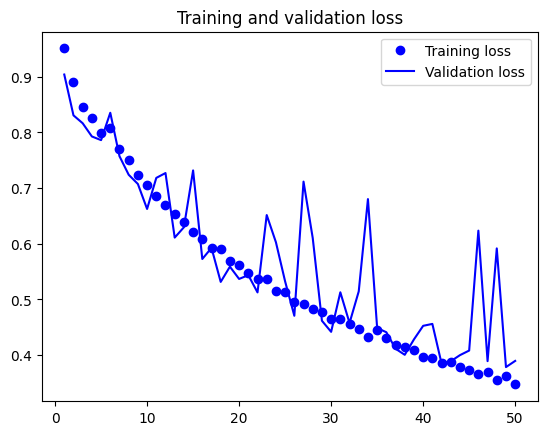

In [11]:
epochs = range(1, len(history.history["loss"])+1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

1/1 [==============================] - 1s 1s/step


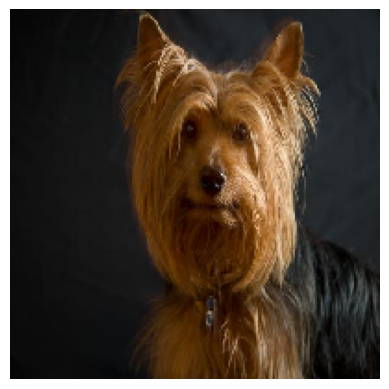

In [12]:
from tensorflow.keras.utils import array_to_img

model = keras.models.load_model("oxford_segmentation.keras")

i=4
test_image = val_input_imgs[i]
plt.axis("off")
plt.imshow(array_to_img(test_image))
## 위치 0에 새 축을 추가하여 test_image 배열의 차원을 확장 - 배치
## 차원을 생성하기 위해 수행(하나의 배치 이미지만 예측)
mask = model.predict(np.expand_dims(test_image,0))[0] ## 예측에서 첫 번째 요소

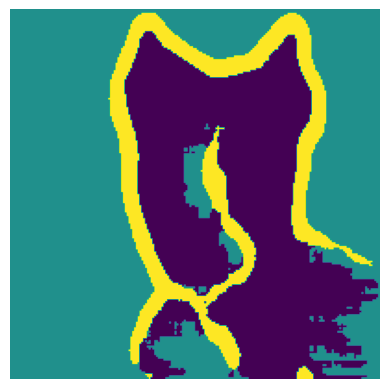

In [13]:
def display_mask(pred):
  mask = np.argmax(pred, axis=-1) ## pred 배열의 마지막 축을 따라 최대값의 인덱스
  mask *= 127
  plt.axis("off")
  plt.imshow(mask)

display_mask(mask)